In [1]:
import sympy as sp
from   sympy import erf, exp, ln, oo, sqrt, Eq, Integral, Max, Symbol
from   sympy.plotting import plot, plot_parametric
from   sympy.stats import density, Normal

In [2]:
class BlackScholes():
    def __init__(self, S=100, K=100, σ=0.5, T=1, t=0, r=0, p=1):
        # Save initial state for further use
        self.S, self.K, self.σ, self.T, self.t, self.r, self.p = S, K, σ, T, t, r, p
        
        S = Symbol('S') # stock price at t (spot)
        F = Symbol('F') # stock price at T (final)
        K = Symbol('K') # strike
        σ = Symbol('σ') # volatility
        T = Symbol('T') # maturity time (in years)
        t = Symbol('t') # forward time; today t=0, t <= T
        r = Symbol('r') # interest rate
        p = Symbol('p') # parity; +1 for CALL, -1 for PUT
        
        # Helpers
        norm_cdf = lambda x: 0.5 * (1 + erf(x * 2**-0.5))
        d1 = 1 / (σ * sqrt(T - t)) * (ln(S / K) + (r + 0.5 * σ * σ) * (T - t))
        d2 = d1 - σ * sqrt(T - t)

        # Option Prices
        #f_call =   S * norm_cdf( d1) - K * exp(-r * (T - t)) * norm_cdf( d2)
        #f_put  = - S * norm_cdf(-d1) + K * exp(-r * (T - t)) * norm_cdf(-d2)
        
        f_price = p * S * norm_cdf(p * d1) - p * K * exp(-r * (T - t)) * norm_cdf(p * d2)
        
        # Forward (Risk-Neutral) Distribution at Maturity
        f_pdf  = density(S * exp((r - 0.5*σ*σ) * (T - t) + σ * sqrt(T - t) * Normal('W', 0, 1)))(F)
        
        
        # PUBLIC METHODS =======================================================

        self.pdf        = self._evalf( f_pdf )
        
        # Greeks
        self.price = self._evalf( f_price )
        self.delta = self._evalf( f_price.diff(S) )
        self.vega  = self._evalf( f_price.diff(σ) )
        self.theta = self._evalf( f_price.diff(t) )
        self.rho   = self._evalf( f_price.diff(r) )
        
        #self.put        = self._evalf( f_put )
        #self.put_delta  = self._evalf( f_put.diff(S) )
        #self.put_vega   = self._evalf( f_put.diff(σ) )
        #self.put_theta  = self._evalf( f_put.diff(t) )
        #self.put_rho    = self._evalf( f_put.diff(r) )


    def _evalf(self, f):
        def wrap(**kwargs):
            subs = {
                'S': self.S,
                'K': self.K,
                'σ': self.σ,
                'T': self.T,
                't': self.t,
                'r': self.r,
                'p': self.p,
                **kwargs
            }
            return f.subs(subs).evalf(subs=subs)
        return wrap


# plot helper
def plot(*args):
    x_range = args[-1]
    p0 = None
    for i in range(0, len(args)-1):
        pi = sp.plotting.plot(args[i], x_range, label=f'#{i}', line_color=f'C{i}', legend=True, show=False)
        if p0 is None:
            p0 = pi
        else:
            p0.extend(pi)
    p0.show()
    return p0


# general-purpose symbol
x = Symbol('x')

## Example: AMD Options

In [13]:
x = Symbol('x') # anything
F = Symbol('F') # forward price

AMD = BlackScholes(K=90, T=45./365, S=82, σ=0.338, r=0, p=1)
AMD.price(p=+1), AMD.price(p=-1)

(1.25835519602241, 9.25835519602241)

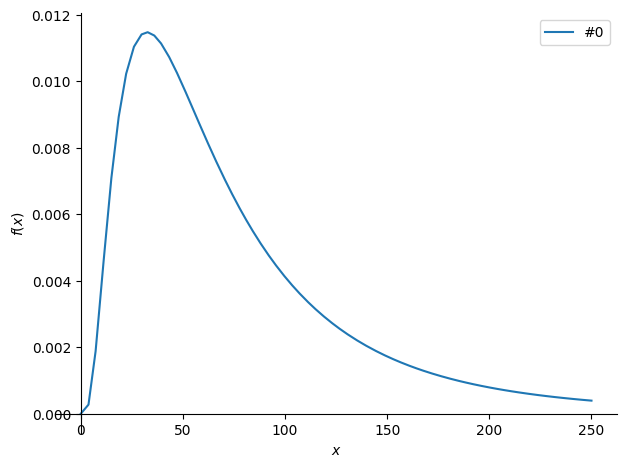

In [11]:
plot(AMD.pdf(F=x, σ=0.75, T=1.1), (x, 0.01, 250))

### Expectation over Risk-Neutral measure

In [5]:
call = Max(F - AMD.K, 0) * AMD.pdf()
put  = Max(AMD.K - F, 0) * AMD.pdf()
call, put

(3.36150329182974*exp(-35.49906827103*(log(F/82) + 0.00704243835616438)**2)*Max(0, F - 90)/Abs(F),
 3.36150329182974*exp(-35.49906827103*(log(F/82) + 0.00704243835616438)**2)*Max(0, 90 - F)/Abs(F))

In [6]:
Integral(put, (F, 0, AMD.K)).evalf(4)

9.258

In [7]:
AMD.pdf()

3.36150329182974*exp(-35.49906827103*(log(F/82) + 0.00704243835616438)**2)/Abs(F)

### Greeks

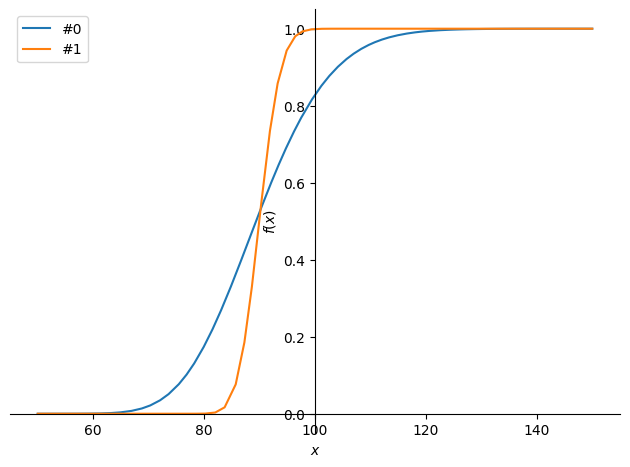

In [8]:
plot(AMD.delta(S=x), AMD.delta(S=x, T=0.01), (x, 50, 150))

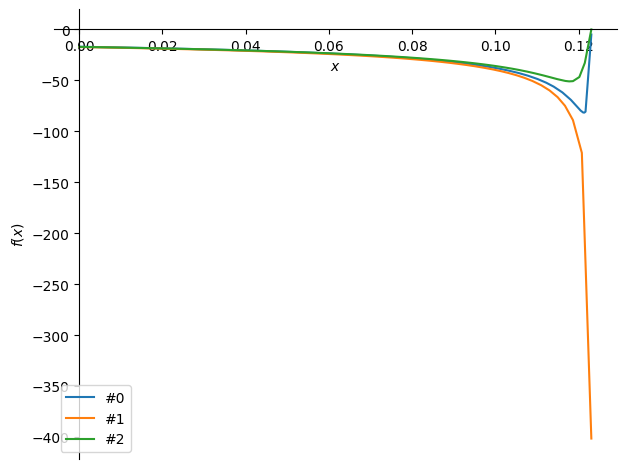

In [9]:
plot(
    AMD.theta(S=0.985*AMD.K, t=x),
    AMD.theta(S=AMD.K, t=x),
    AMD.theta(S=1.025*AMD.K, t=x),
    
    (x, 0.0, AMD.T - 2./365/24))